In [1]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from tabulate import tabulate
from urllib.parse import urlparse, parse_qsl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from django.db.models import Count
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from django.db.models import F, Sum, Count

from utils.utils import *

import statsmodels.formula.api as sm, statsmodels.stats.api as sms


run_id=372

runstat = RunStats.objects.get(pk=run_id)

In [2]:


dts = DocTopic.objects.filter(
    run_id=run_id,
    doc__PY__lt=2014,
    score__gt=runstat.dthreshold
).values('topic__title')

dts = dts.annotate(
    ipcc = models.Sum(
        models.Case(
            models.When(doc__ipccref__isnull=False,then=F('score')),default=0, output_field=models.FloatField()
        )
    ),
    no_ipcc = models.Sum(
        models.Case(
            models.When(doc__ipccref__isnull=True,then=F('score')),default=0, output_field=models.FloatField()
        )
    )
)
df =  pd.DataFrame.from_dict(list(dts))

In [3]:
df['total'] = df.ipcc+df.no_ipcc
df['ipcc_pcnt'] = df.ipcc/df.total*100
df = df.sort_values(by='ipcc_pcnt', ascending=0).reset_index(drop=True)
df.head()

,ipcc,no_ipcc,topic__title,total,ipcc_pcnt
0,46.950550,94.558594,"{cloud, aerosol, radiat}",141.509143,33.178457
1,34.544229,75.578628,"{adapt, vulner, strategi}",110.122857,31.368809
2,28.850363,73.675496,"{ozon, stratospher, tropospher}",102.525859,28.139597
3,33.798013,88.510284,"{project, uncertainti, futur}",122.308296,27.633459
4,34.549259,93.301110,"{scenario, futur, simul}",127.850369,27.023198


In [15]:
df = pd.DataFrame.from_dict(
        list(Topic.objects.filter(
            run_id=run_id,
            topicarscores__ar=5,
            topicarscores__share__gt=0.005
        ).order_by('-ipcc_coverage').values('title','ipcc_coverage'))
)

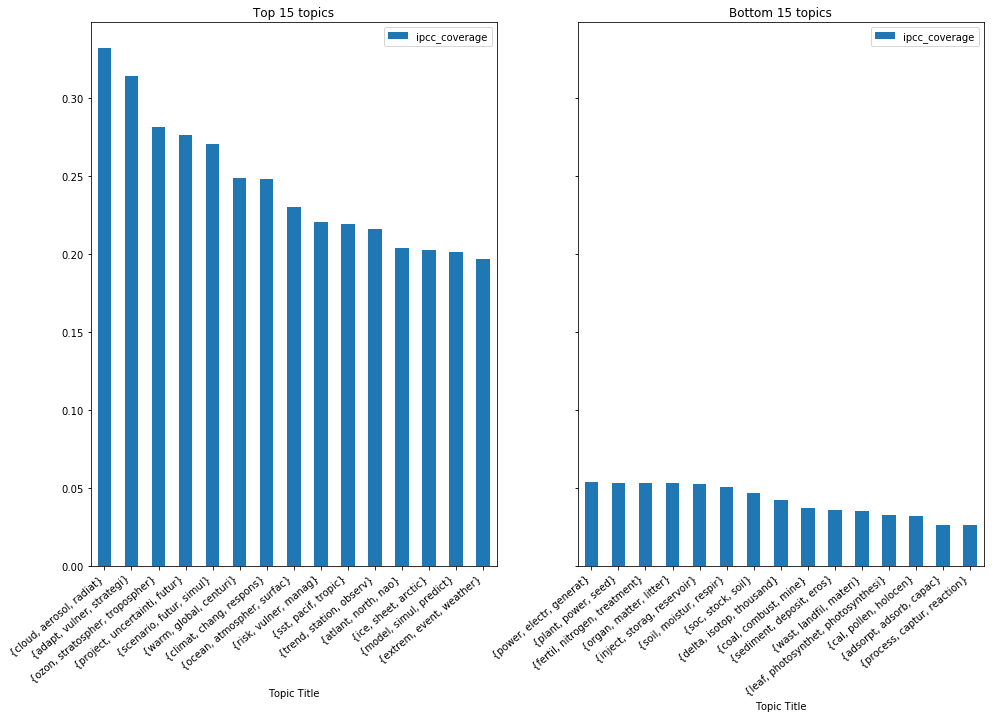

In [29]:
plt.rcParams["figure.figsize"] = [16,10]

fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    sharey=True,
    gridspec_kw=dict(hspace=0.4))

n = 15

i=0
for ax in axs:

    bdf = df.set_index(['title'])[['ipcc_coverage']]
    
    #ax.set_ylim([0, 20])
    
    if i==0:
        bdf.head(n).plot.bar(ax=ax)
        ax.set_title('Top {} topics'.format(n))
    else:
        bdf.tail(n).plot.bar(ax=ax)
        ax.set_title('Bottom {} topics'.format(n))
        
    i+=1
    
    ax.set_xlabel('Topic Title')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    
plt.xlabel('Topic Title')

plt.savefig('../plots/ipcc_topics_{}.png'.format(run_id),bbox_inches='tight')   
plt.show()

In [5]:
ipccdocs = DocTopic.objects.filter(
    doc__ipccref__isnull=False,
    run_id=run_id
).values('topic__title','doc__ipccref__ar','doc__ipccref__wg__wg').annotate(
    score=Sum('score'),
    count=Count('doc',distinct=True)
)
ipdf_tops =  pd.DataFrame.from_dict(list(ipccdocs)).rename(columns={'doc__ipccref__ar':'AR','doc__ipccref__wg__wg':'WG'})
#ipdf.head()

In [6]:
wgtcounts = DocTopic.objects.filter(
    doc__ipccref__isnull=False,
    run_id=run_id
).values('doc__ipccref__ar','doc__ipccref__wg__wg').annotate(
    wgt_score=Sum('score'),
    wgt_count=Count('doc',distinct=True)
)
wgtc =  pd.DataFrame.from_dict(list(wgtcounts)).rename(columns={'doc__ipccref__ar':'AR','doc__ipccref__wg__wg':'WG'})
wgtc.head()

,AR,WG,wgt_count,wgt_score
0,2.0,1.0,249,28.145203
1,2.0,2.0,132,15.746483
2,2.0,3.0,28,2.823865
3,3.0,1.0,733,90.828607
4,3.0,2.0,798,110.527855


In [7]:
wgcounts = IPCCRef.objects.all().values('ar','wg__wg').annotate(
    wg_count=Count('pk',distinct=True)
)
wgc =  pd.DataFrame.from_dict(list(wgcounts)).rename(columns={'ar':'AR','wg__wg':'WG'})
wgc.head(15)

,AR,WG,wg_count
0,1.0,1.0,901
1,1.0,2.0,724
2,1.0,3.0,62
3,2.0,1.0,2010
4,2.0,2.0,2844
5,2.0,3.0,1731
6,3.0,1.0,4635
7,3.0,2.0,6554
8,3.0,3.0,2863
9,4.0,1.0,5883


In [8]:
ipdf = ipdf_tops.merge(wgc).merge(wgtc)
ipdf.head()

,count,AR,WG,score,topic__title,wg_count,wgt_count,wgt_score
0,44,2.0,1.0,0.025811,"{adapt, vulner, strategi}",2010,249,28.145203
1,75,2.0,1.0,0.094206,"{adsorpt, adsorb, capac}",2010,249,28.145203
2,124,2.0,1.0,0.614320,"{atlant, north, nao}",2010,249,28.145203
3,61,2.0,1.0,0.019692,"{biochar, amend, pyrolysi}",2010,249,28.145203
4,63,2.0,1.0,0.129819,"{biomass, aboveground, bioenergi}",2010,249,28.145203


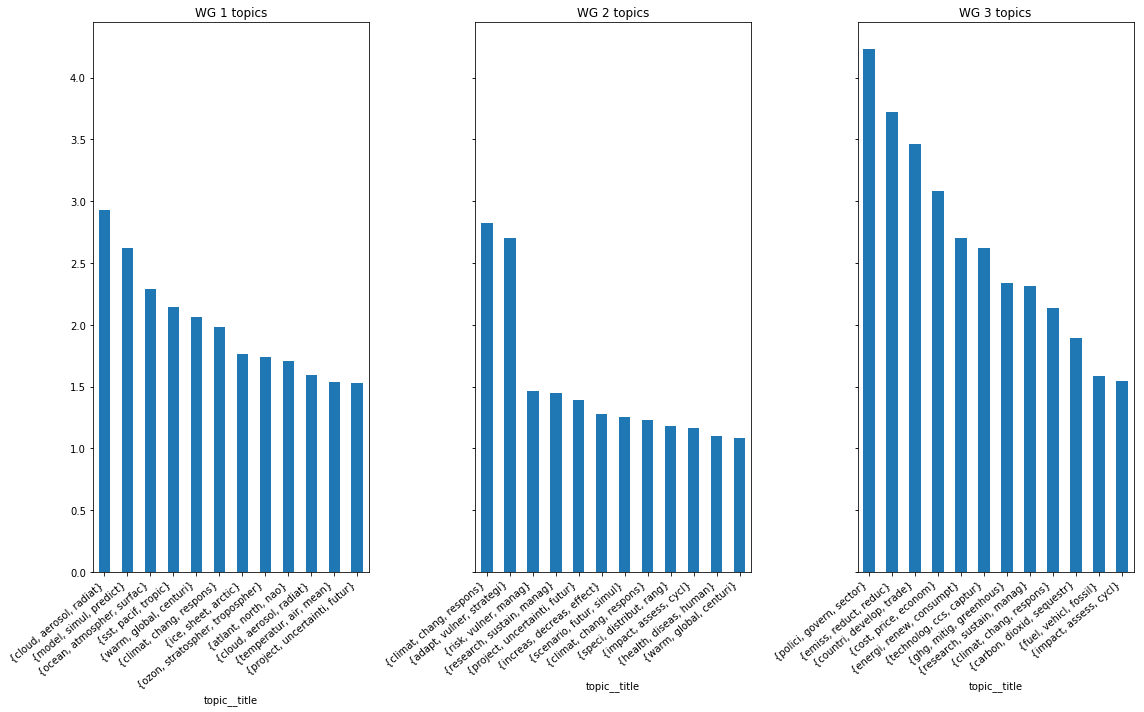

In [9]:
plt.rcParams["figure.figsize"] = [16,10]

fig, axs = plt.subplots(
    nrows=1,
    ncols=3,
    sharey=True
)

grouped = ipdf.groupby('WG')

targets = zip(grouped.groups.keys(), axs.flatten())

n = 12

for i, (key, ax) in enumerate(targets):
#for name, group in ipdf.groupby('WG'):
    group = grouped.get_group(key).set_index(['topic__title'])
    group = group.sort_values('score',ascending=False)
    group['sum'] = group['score'].sum()
    group['share'] = group['score'] / group['sum']*100
    ax.set_title('WG {:.0f} topics'.format(key))
    group.head(n)['share'].plot.bar(ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.tight_layout()
plt.show()

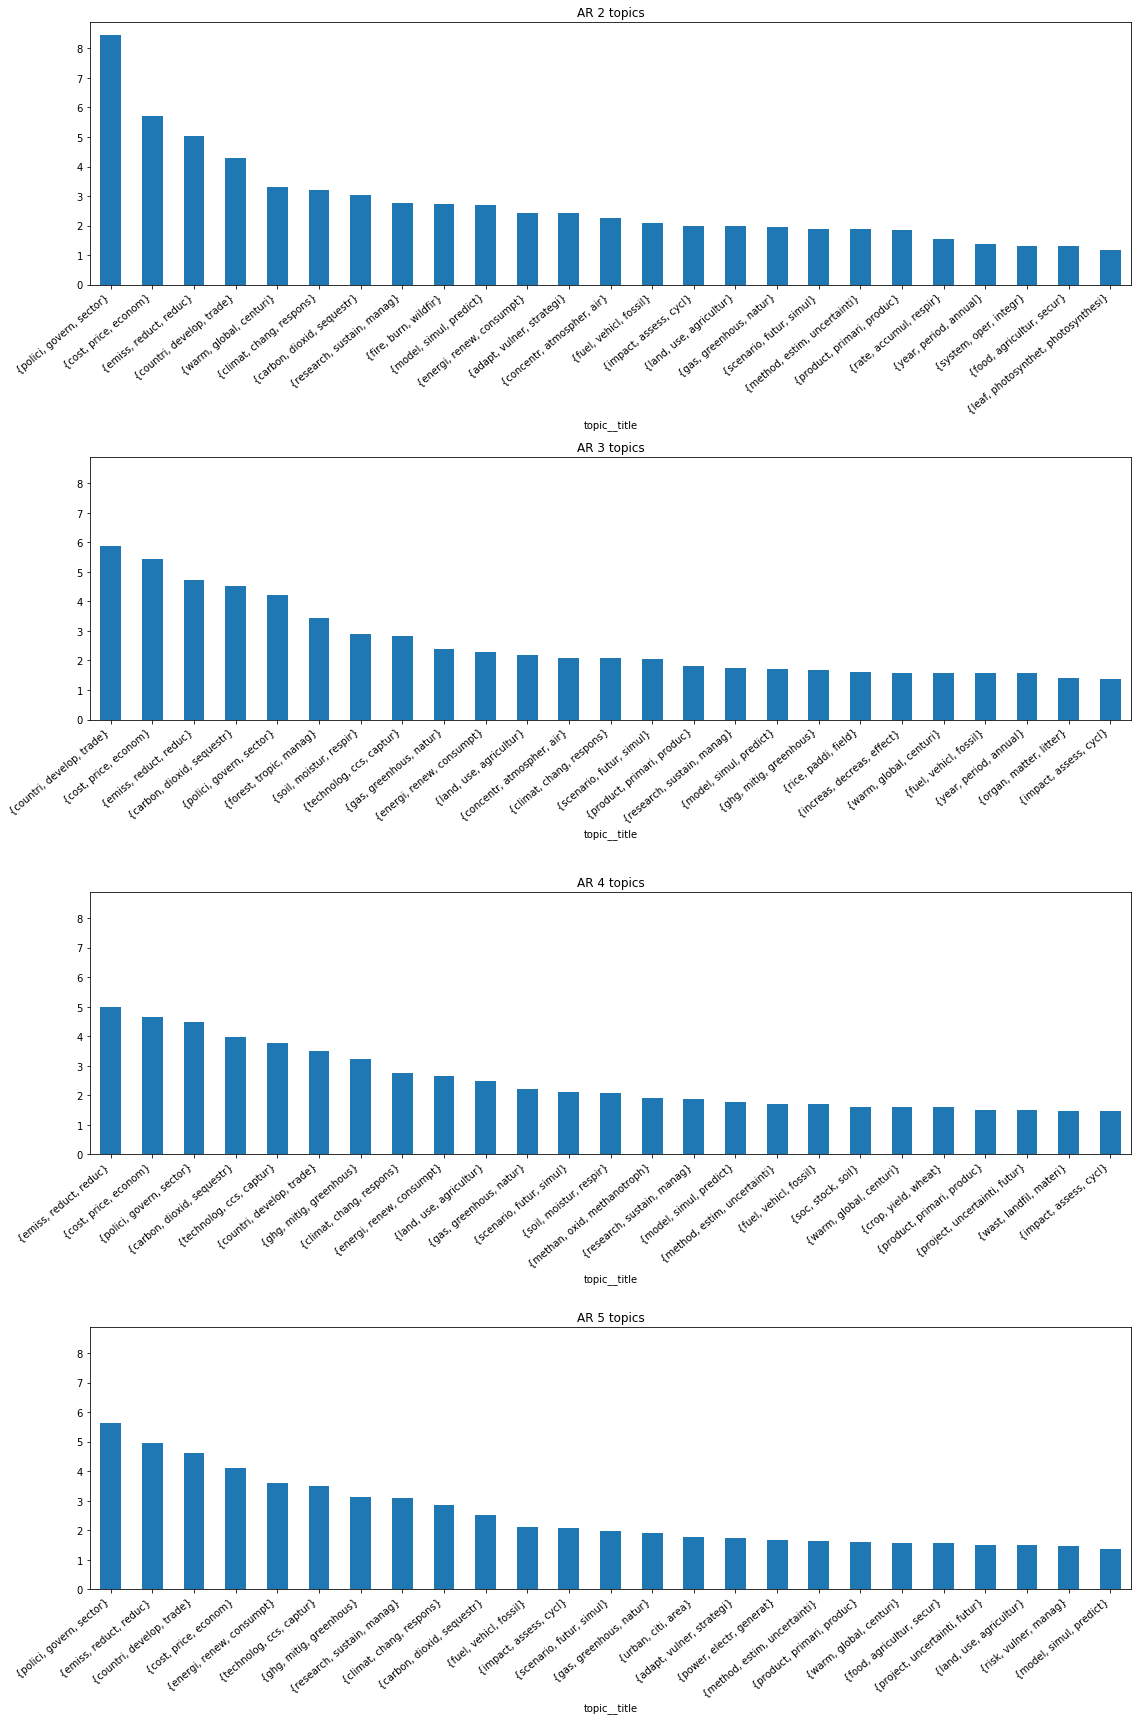

In [10]:
plt.rcParams["figure.figsize"] = [16,24]

fig, axs = plt.subplots(
    nrows=4,
    ncols=1,
    sharey=True#,
    #gridspec_kw=dict(hspace=0.4,)
)

grouped = ipdf[ipdf['WG']==3].groupby('AR')

targets = zip(range(2,6), axs.flatten())

n = 25

for i, (key, ax) in enumerate(targets):
#for name, group in ipdf.groupby('WG'):
    group = grouped.get_group(key).set_index(['topic__title'])
    group = group.sort_values('score',ascending=False)
    group['sum'] = group['score'].sum()
    group['share'] = group['score'] / group['sum']*100
    ax.set_title('AR {:.0f} topics'.format(key))
    group.head(n)['share'].plot.bar(ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.tight_layout()
plt.show()

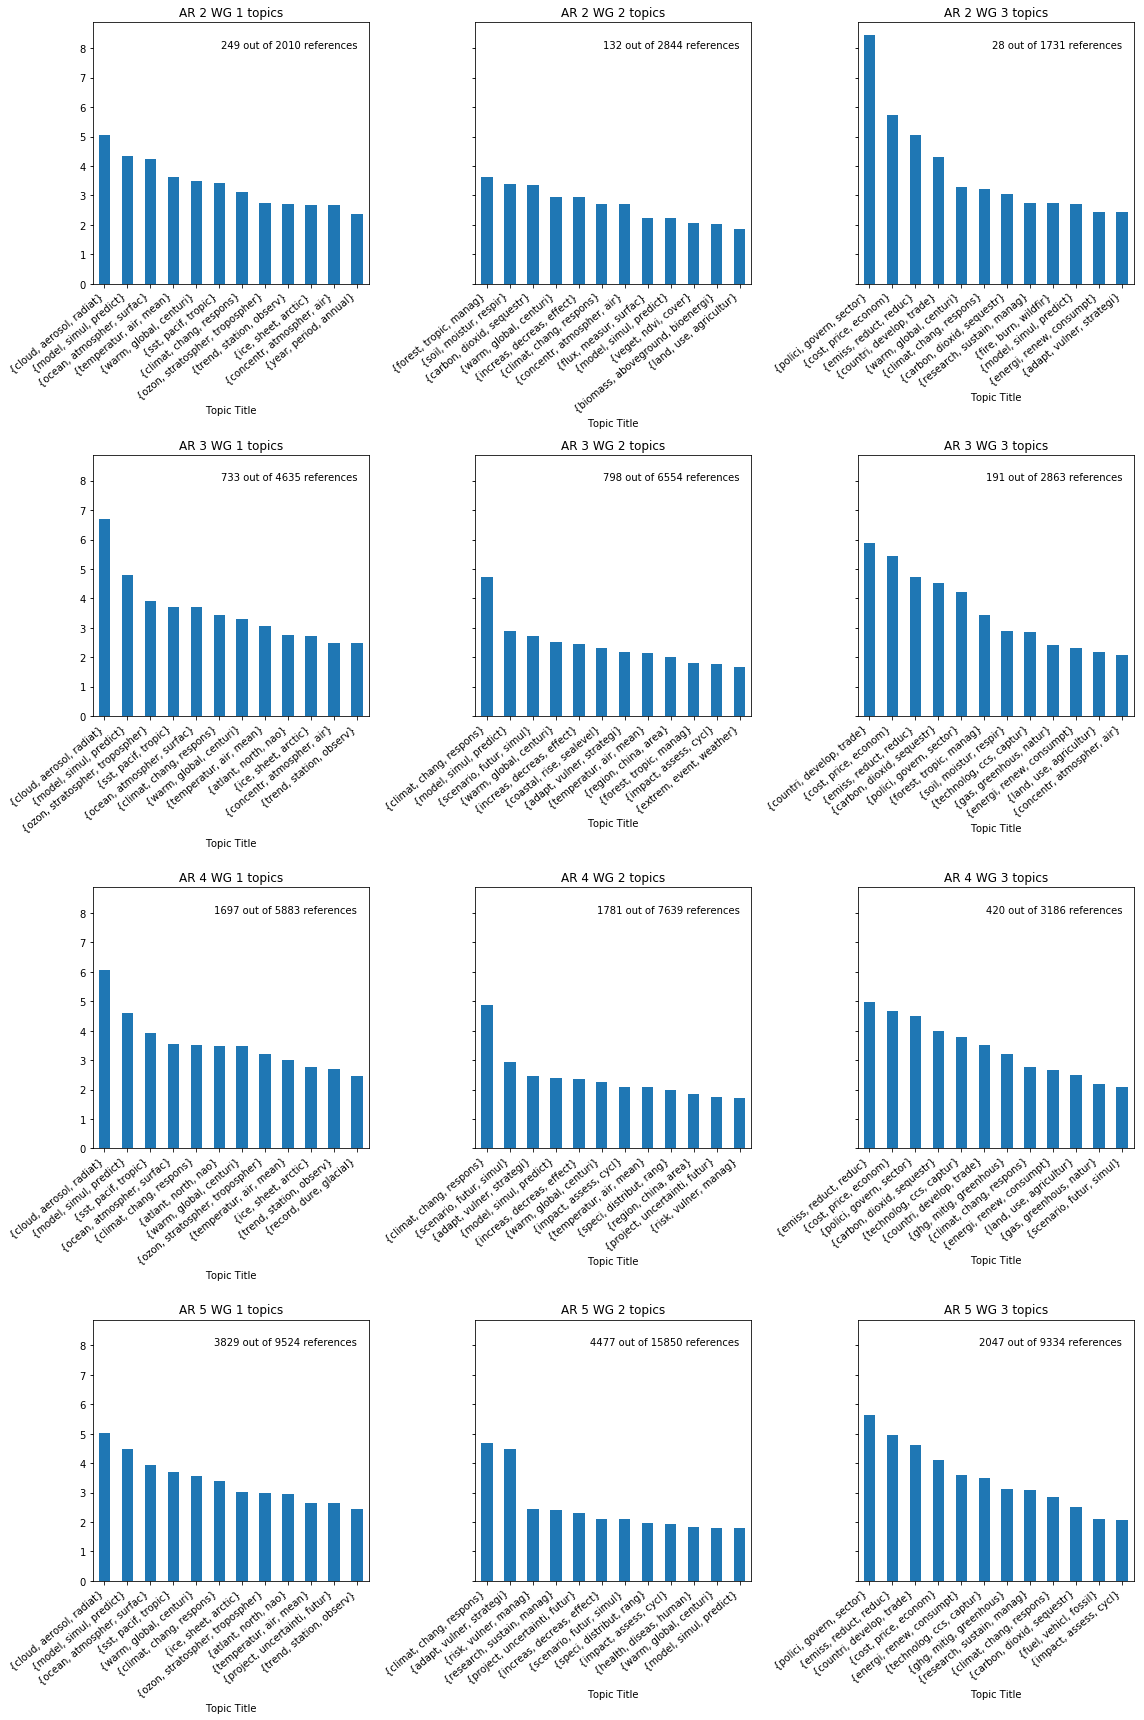

In [11]:
plt.rcParams["figure.figsize"] = [16,24]

fig, axs = plt.subplots(
    nrows=4,
    ncols=3,
    sharey=True#,
    #gridspec_kw=dict(hspace=0.4,)
)

grouped = ipdf.dropna().sort_values(['AR','WG']).groupby(['AR','WG'])

arorder = []
for x in range(2,6):
    for y in range(1,4):
        arorder.append((float(x),float(y)))

targets = zip(arorder, axs.flatten())

n = 12

for i, (key, ax) in enumerate(targets):
    group = grouped.get_group(key).set_index(['topic__title'])
    group = group.sort_values('score',ascending=False)
    group['sum'] = group['score'].sum()
    group['share'] = group['score'] / group['sum']*100
    ax.set_title('AR {:.0f} WG {:.0f} topics'.format(key[0],key[1]))
    group.head(n)['share'].plot.bar(ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    ax.set_xlabel('Topic Title')
    text = "{} out of {} references".format(group['wgt_count'][0],group['wg_count'][0])
    ax.text(n-1,8,text,ha="right")

plt.tight_layout()

plt.savefig('../plots/ipcc_topics_ars_{}.png'.format(run_id),bbox_inches='tight')   
plt.show()

plt.show()

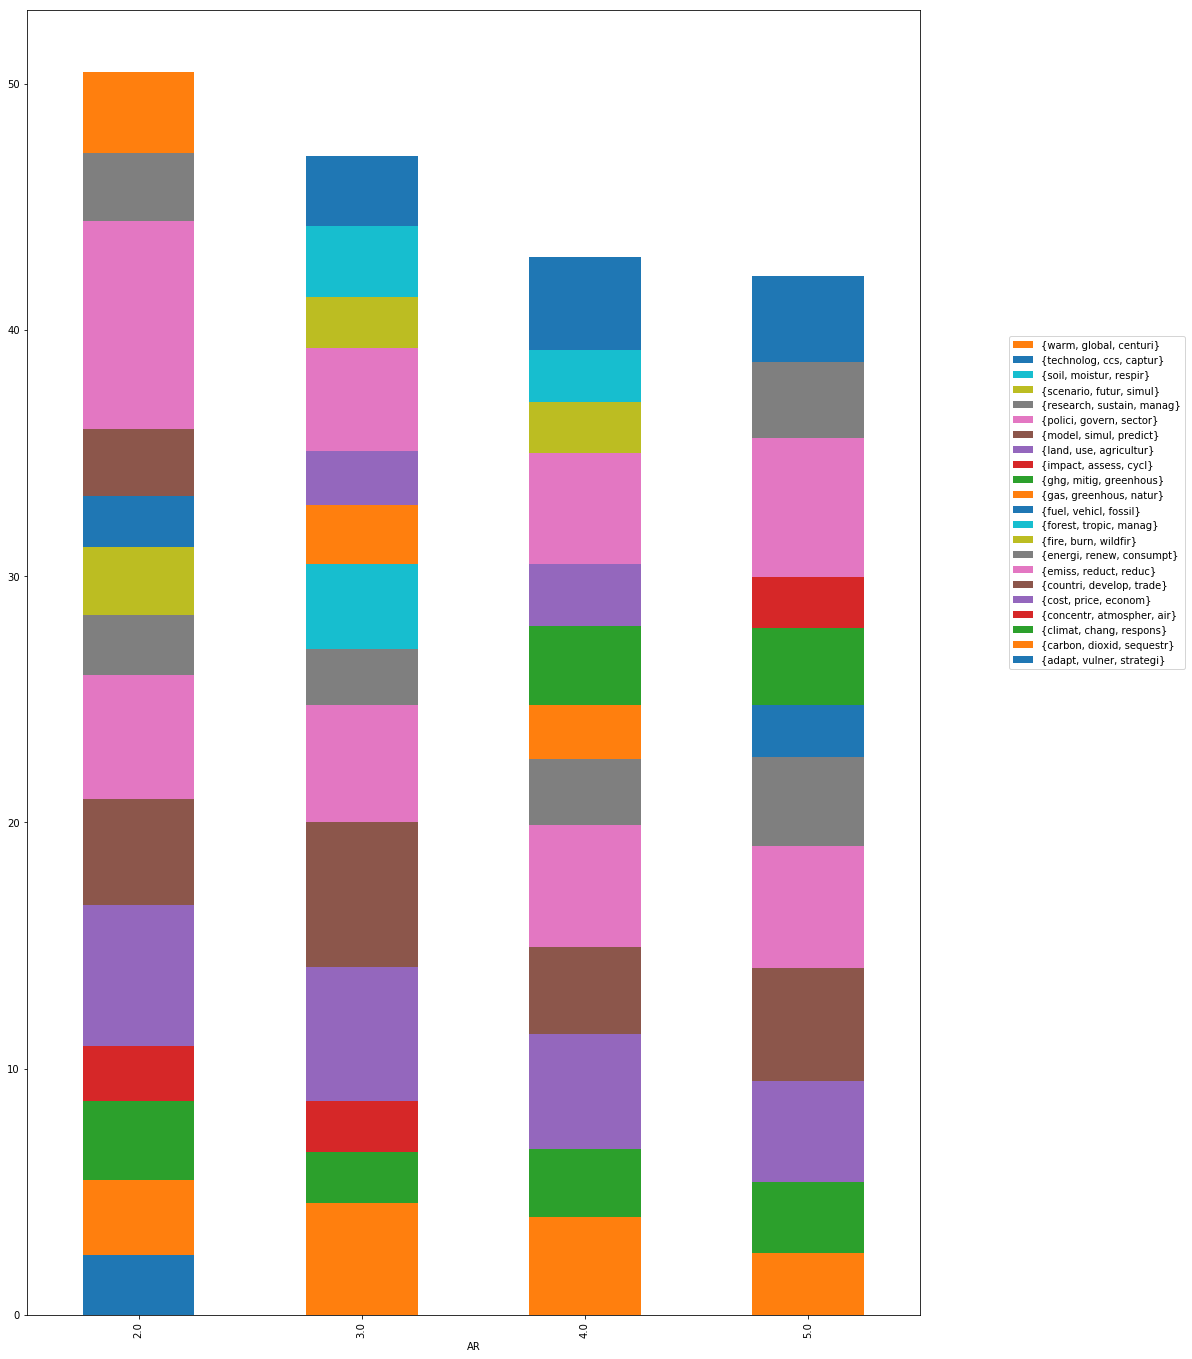

In [12]:
wg3 = ipdf[ipdf['WG']==3].dropna().sort_values(['AR','WG'])

wg3['share'] = wg3['score'] / wg3['wgt_score']*100

wg3 = wg3[wg3['share']>2]

wg3 = wg3[wg3['AR']>1]

wg3 = pd.pivot_table(
                wg3,
                values='share',
                index='AR',
                columns='topic__title'
            )
wg3.head()

fig, ax = plt.subplots()

#ax = enumerate(axs)[0]

wg3.plot.bar(stacked=True,ax=ax)

handles, labels = ax.get_legend_handles_labels()

lpos = (1.1,0.75)

ax.legend(reversed(handles), reversed(labels),bbox_to_anchor=lpos, loc=2, borderaxespad=.0,)

plt.show()

In [13]:
wgs = [
    {"WG":1, "score": 0},
    {"WG":2, "score": 0},
    {"WG":3, "score": 0}
]
for topic in Topic.objects.filter(run_id=run_id):
    tdocs = Doc.objects.filter(doctopic__topic=topic,doctopic__score__gt=runstat.dthreshold)
    for wg in wgs:
        wgdocs = tdocs.filter(ipccref__wg__wg=wg["WG"])
        if wgdocs.count() == 0:
            wg['score'] = 0
        else:
            wg['score'] = wgdocs.aggregate(s = Sum('doctopic__score'))['s']       
    maxwg =  max(wgs, key=lambda x:x['score'])
    tscore = sum(x['score'] for x in wgs)
    if tscore==0:
        tscore=1
    topic.wg_1 = wgs[0]['score'] / tscore
    topic.wg_2 = wgs[1]['score'] / tscore
    topic.wg_3 = wgs[2]['score'] / tscore
    topic.primary_wg = maxwg['WG']
    topic.wg_prop = maxwg['score'] / tscore
    topic.save()

In [14]:
wgdts = DocTopic.objects.filter(topic__run_id=run_id).values('doc__PY','topic__title').annotate(
    score = Sum('score')
)


wgpy = pd.DataFrame.from_dict(list(wgdts.values('topic__title','score','doc__PY','topic__wg_1','topic__wg_2','topic__wg_3')))

wgpy.head()

,doc__PY,score,topic__title,topic__wg_1,topic__wg_2,topic__wg_3
0,2003,1.705413,"{coral, bleach, stress}",0.098401,0.895932,0.005667
1,1994,0.698861,"{groundwat, recharg, aquif}",0.106169,0.839836,0.053995
2,1992,1.050565,"{lake, level, diatom}",0.267412,0.724334,0.008254
3,2012,17.699653,"{land, use, agricultur}",0.400852,0.385615,0.213533
4,1993,0.963461,"{river, basin, runoff}",0.223472,0.758737,0.017791


In [15]:
wgpy_dict = []

for py in range(1990,2017):
    for wg in wgs:
        wgscore = 0
        for t in wgdts.values('topic__id','doc__PY','score').filter(doc__PY=py):
            top = Topic.objects.get(id=t['topic__id'])
            score = t['score'] * getattr(top,"wg_{}".format(wg['WG']))
            wgscore += score
        wgpy_dict.append({
            'PY': py,
            'WG': wg['WG'],
            'score': wgscore
        })

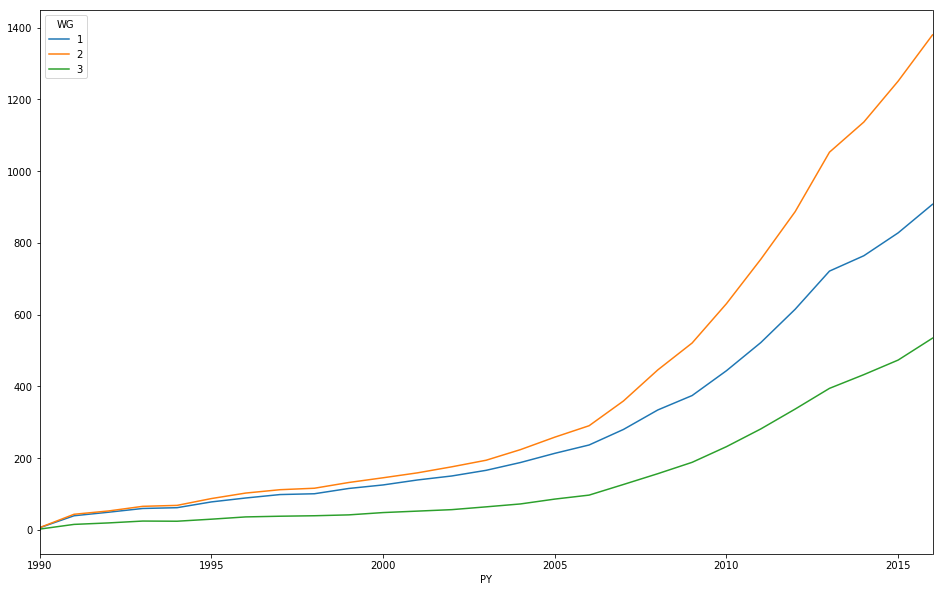

In [16]:
plt.rcParams["figure.figsize"] = [16,10]

wgpy = pd.DataFrame.from_dict(wgpy_dict)

wgpy.head()

wgpy_wide = pd.pivot_table(
    data=wgpy,
    index='PY',
    columns='WG',
    values='score'
)

wgpy_wide.head()

wgpy_wide.plot()

plt.show()




1


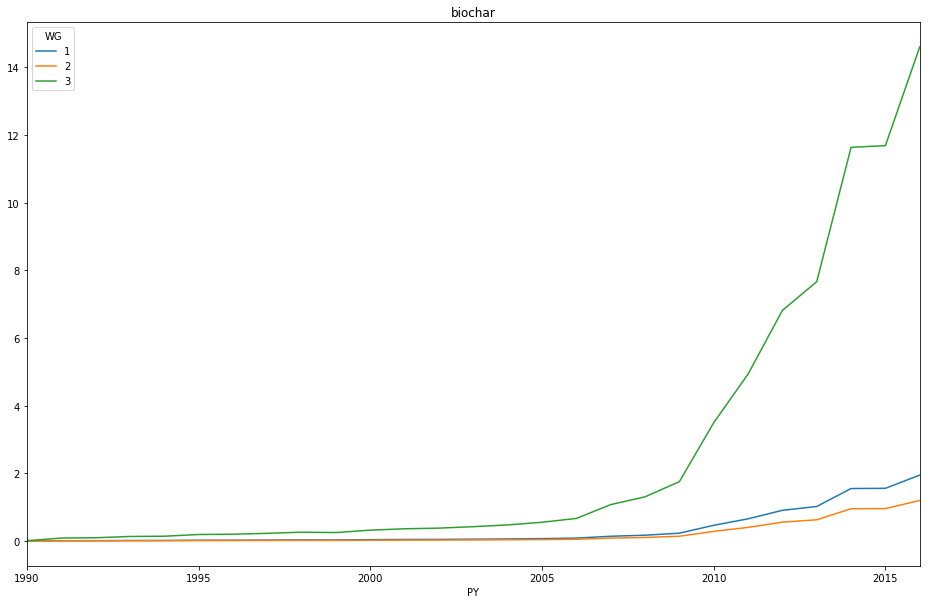

In [17]:
tword = "biochar"

sus = Topic.objects.filter(run_id=run_id,title__icontains=tword)

print(sus.count())

sus_scores = []

for py in range(1990,2017):
    for wg in wgs:
        wgscore = 0
        for t in wgdts.values('topic__id','doc__PY','score').filter(doc__PY=py,topic__in=sus):
            top = Topic.objects.get(id=t['topic__id'])
            score = t['score'] * getattr(top,"wg_{}".format(wg['WG']))
            wgscore += score
        sus_scores.append({
            'PY': py,
            'WG': wg['WG'],
            'score': wgscore
        })
sus_df = pd.DataFrame.from_dict(sus_scores)

sus_wide = pd.pivot_table(
    data=sus_df,
    index='PY',
    columns='WG',
    values='score'
)

sus_wide.plot()

plt.title(tword)

plt.show()


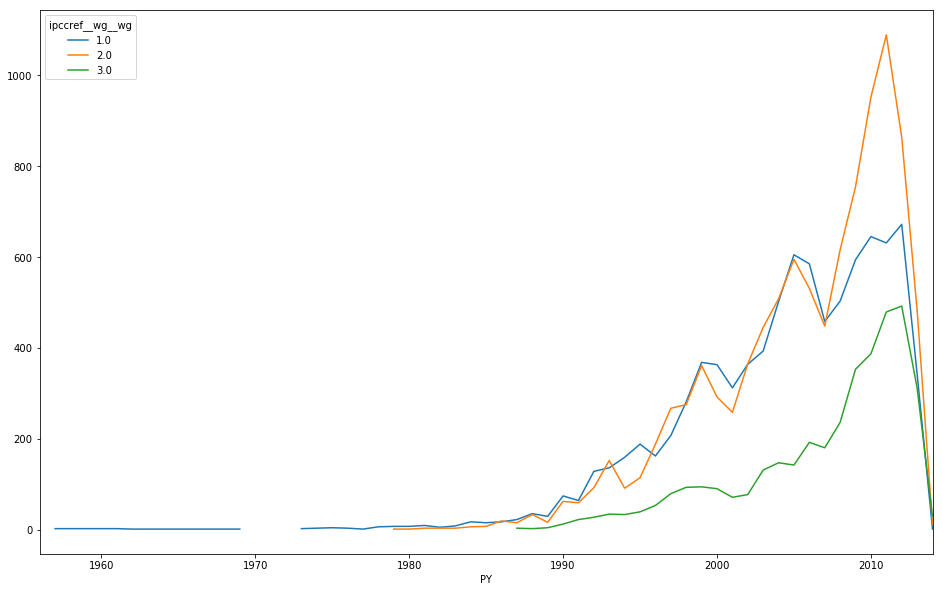

In [18]:
iprs = Doc.objects.filter(ipccref__isnull=False).values('PY','ipccref__wg__wg').annotate(
    n = Count('UT')
)

ippy = pd.DataFrame.from_dict(list(iprs))

ippy_wide = pd.pivot_table(
    data=ippy,
    index='PY',
    columns='ipccref__wg__wg',
    values='n'
)


ippy_wide.plot()

plt.show()

In [19]:
tcs = TopicCorr.objects.filter(run_id=run_id).filter(score__gt=0.05,score__lt=1).annotate(
        source=F('topic'),
        target=F('topiccorr')
    )



tcdf = pd.DataFrame.from_dict(list(tcs.values('topic','topiccorr','topic__primary_wg','topiccorr__primary_wg','score')))

def issame(x):
    if x['topic__primary_wg']==x['topiccorr__primary_wg']:
        return 1
    else:
        return 0

tcdf['samewg'] = tcdf.apply(lambda x: issame(x) ,axis=1)

tcdf.head()

,score,topic,topic__primary_wg,topiccorr,topiccorr__primary_wg,samewg
0,0.065736,107955,1,107959,1,1
1,0.059169,107955,1,107966,1,1
2,0.134742,107955,1,107974,2,0
3,0.054521,107955,1,107985,1,1
4,0.055319,107955,1,107988,1,1


In [20]:
result = sm.ols(formula="score ~ samewg + topic__primary_wg", data=tcdf).fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     66.35
Date:                Wed, 08 Nov 2017   Prob (F-statistic):           2.17e-29
Time:                        16:55:26   Log-Likelihood:                -1798.9
No. Observations:               12426   AIC:                             3604.
Df Residuals:                   12423   BIC:                             3626.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.2835      0.00

In [21]:
X1, X2 = np.arange(10,21), np.arange(20,26.5,.5)

cm = sms.CompareMeans(sms.DescrStatsW(X1), sms.DescrStatsW(X2))
print(cm.tconfint_diff(usevar='unequal'))

(-10.414599391793885, -5.5854006082061138)


In [22]:
from scipy.stats import ttest_ind

cat1 = tcdf[tcdf['samewg']==1]
cat2 = tcdf[tcdf['samewg']==0]


ttest_ind(cat1['score'], cat2['score'])

Ttest_indResult(statistic=-11.182287039975515, pvalue=6.8397692639552118e-29)

           score
samewg          
0       0.264567
1       0.208237
           score
samewg          
0       0.306918
1       0.254595


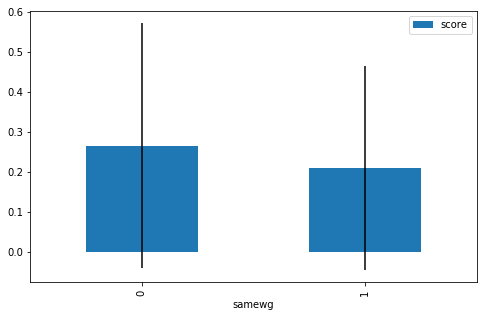

In [23]:
plt.rcParams["figure.figsize"] = [8,5]

gp = tcdf[['score','samewg']].groupby('samewg')

means = gp.mean()

print(means)

errors = gp.std()

print(errors)

fig, ax = plt.subplots()

means.plot(yerr=errors, ax=ax, kind='bar')

plt.show()


In [24]:
dts = DocTopic.objects.filter(run_id=run_id)

df = pd.DataFrame(list(dts.values('doc_id','topic_id','score')))

df = df.pivot(index='doc_id',columns='topic_id',values='score').fillna(0)

corr = df.corr()

corr['topic1'] = corr.index


In [25]:
topics = Topic.objects.filter(run_id=run_id)
tdf = pd.DataFrame.from_dict(list(topics.values('id','primary_wg')))


tdf.head()

,id,primary_wg
0,108044,3
1,108046,3
2,108047,1
3,108049,3
4,108043,2


In [26]:
corrlong = pd.melt(corr,id_vars=['topic1'])
corrlong = corrlong[corrlong['value']<1]

mask = corrlong['topic1'] < corrlong['topic_id']

corrlong['first'] = corrlong['topic1'].where(mask, corrlong['topic_id'])
corrlong['second'] = corrlong['topic_id'].where(mask, corrlong['topic1'])

corrlong = corrlong.drop_duplicates(subset=['value', 'first', 'second'])[['topic1','topic_id','value']].rename(columns={
    'topic1':'topic1','topic_id':'topic2'
})

tdf1 = tdf.rename(columns={
    'id':'topic1',
    'primary_wg': 'wg_1'
})

tdf2 = tdf.rename(columns={
    'id':'topic2',
    'primary_wg': 'wg_2'
})

corrlong = corrlong.merge(tdf1).merge(tdf2)

def issame(x):
    if x['wg_1']==x['wg_2']:
        return 1
    else:
        return 0

corrlong['samewg'] = corrlong.apply(lambda x: issame(x) ,axis=1)


corrlong.head()

,topic1,topic2,value,wg_1,wg_2,samewg
0,107956,107955,-0.080398,3,1,0
1,107957,107955,0.020441,2,1,0
2,107958,107955,0.014956,2,1,0
3,107959,107955,0.057093,1,1,1
4,107960,107955,-0.054874,2,1,0


           value
samewg          
0      -0.011846
1       0.013001
           value
samewg          
0       0.040510
1       0.054401


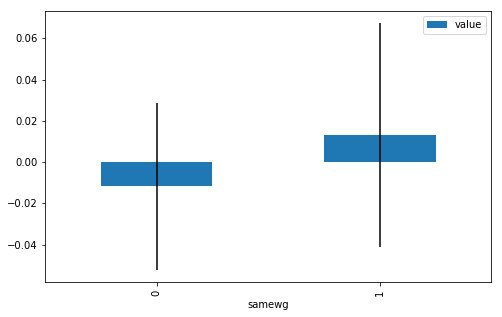

In [27]:
gp = corrlong[['value','samewg']].groupby('samewg')

means = gp.mean()

print(means)

errors = gp.std()

print(errors)

fig, ax = plt.subplots()

means.plot(yerr=errors, ax=ax, kind='bar')

plt.show()

In [28]:
from scipy.stats import ttest_ind

cat1 = corrlong[corrlong['samewg']==1]
cat2 = corrlong[corrlong['samewg']==0]


ttest_ind(cat1['value'], cat2['value'])

Ttest_indResult(statistic=18.410706564927157, pvalue=2.8741559949464013e-73)